In [4]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 350
plt.rcParams["lines.markersize"] = 5
plt.rcParams['lines.marker'] = 's'
plt.rcParams['axes.formatter.use_mathtext'] = True
def get_vs_ncores(nfiles, ncores_range=range(8, 65, 8), labels = ['O3', 'coffea'], subdir=''):
#     plt.style.use('_mpl-gallery')
    
    colors = ['r', 'g', 'b', 'y']
    colors = {labels[i]:colors[i] for i in range(len(labels))}
    
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    timeax = ax[0]
    ramax = ax[1]
    
    fig_rate, axs = plt.subplots(1,2, figsize=(12,5)) 
    ax_rate = axs[0]
    ax_file = axs[1]
    
    n = ncores_range
    nevts = []
    nfiles_tot = []
    

    for label in labels:
        
        t = []  
        ram = []
        for ncores in n:
            path = f'benchmarks/{subdir}{nfiles}/{label}/{ncores}/*'
            files = glob.glob(path)
            
#             print(files)
#             print(len(files), path[:-1])
#             if min_nfiles == -1:
#                 min_nfiles = len(files)
#             else:
#                 if len(files) >= min_nfiles:
#                     files=files[:min_nfiles]
#                 else:
#                     raise Exception(f'in {path[-1]} was founded {len(files)} that is smaller than {min_nfiles}')
            time = []
            rss = []
            
            for i in range(len(files)):
                file = files[i]
                if int(file.split('/')[-1].split('.')[0]) > 2: continue
#                 if 'O1' in file: print(file)
                with open(file, 'r') as f:
                
                    if i == 0 and label=='O3':
                        for l in f.readlines():

                            if 'Total number of events:' in l:
                                val = int(l.split()[-1])
                                nevts.append(val)
                            if 'Total number of files:' in l:
                                val = int(l.split()[-1])    
                                nfiles_tot.append(val) 
                        f.seek(0)
                            
                    if 'coffea' in label:
                        if 'rss' in file:
                            line = f.readline()
                            val = line.split()[0]
                            rss.append(float(val))
                        elif label == 'coffea':
                            omit_first = False
                            for line in f.readlines():
                                if '100%' in line:
                                    if not omit_first:
                                        omit_first = True
                                        continue
                                    
                                    mins = line.split()[-2].split('min')[0] if 'min' in line else 0
                                    secs = line.split()[-1].split('s')[0] if 's' in file else 0
#                                     print(line, mins, secs)
                                    time.append(60*float(mins)+float(secs))
                                    break
                        else:
                            for line in f.readlines():
                                if line.startswith('processing took'):
                                    val = float(line.split()[-2])
                                    time.append(val)     
                    else:
                        for line in f.readlines():
                            if 'RunGraphs' in line and 'elapsed' in line:
                                val = float(line.split()[-2][0:-1])
                                time.append(val)
                            if 'maxresident' in line:
                                val = int(line.split()[-1].split('maxresident')[0])#/100000
                                rss.append(val)
                        
            if time and rss: t.append(time); ram.append(rss)
            else: print(files)

        t = np.array(t); ram = np.array(ram)/1e6
        
        
#         print(t.shape)
#         print(ram.shape)
#         print(np.array(nevts).shape)
#         print(np.array(nfiles_tot).shape)        

        label1 = label.strip('coffea')
        label1 = 'Dask' if len(label1) == 0 else label1
        if label1 == '.FuturesExecutor': label1 = 'Futures'


        timeax.errorbar(n, np.mean(t, axis=1), yerr=np.std(t, axis=1), label = label1, linestyle='', color=colors[label], capsize=5)
        ramax.errorbar(n, np.mean(ram, axis=1), yerr=np.std(ram, axis=1), label = label1, linestyle='', color=colors[label],linewidth=0.7, capsize=5)
        
        
        rate = np.array(nevts)[:,None]/np.array(n)[:,None]/t
        ax_rate.errorbar(n, np.mean(rate, axis=1), yerr=np.std(rate, axis=1), label = label1, linestyle='', color=colors[label], capsize=5)
        rate = np.array(nfiles_tot)[:,None]/np.array(n)[:,None]/t
        ax_file.errorbar(n, np.mean(rate, axis=1), yerr=np.std(rate, axis=1), label = label1, linestyle='', color=colors[label], capsize=5)
        
        
    timeax.set_xlabel('Number of cores')
    timeax.set_ylabel('t [s]')
    timeax.grid()
    timeax.set_xticks(n)
#     ax[0].set_yticks(list(range(0, 1100, 100)))
    #ax[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    timeax.legend()
    timeax.set_title(f'time at {nfiles} files per sample', fontsize=14, x=0.5, y=1.03)
    timeax.set_ylim(0, 900)
 
    ax_rate.set_xlabel('Number of cores')
    ax_rate.set_ylabel('rate of events [Hz]')
    ax_rate.grid()
    ax_rate.set_xticks(n)
    ax_rate.legend()
    ax_rate.set_title(f'rate at {nfiles} files per sample', fontsize=14, x=0.5, y=1.03)
    ax_rate.set_ylim(0, 25*1e4)

    
    ramax.set_xlabel('Number of cores')
    ramax.set_ylabel('RAM [G]')
    ramax.grid()
    ramax.set_xticks(n)
    ramax.legend()
    ramax.set_title(f'RAM at {nfiles} files per sample', fontsize=14, x=0.5, y=1.03)
    ramax.set_ylim(0, 90)

    ax_file.set_xlabel('Number of cores')
    ax_file.set_ylabel('rate of files [Hz]')
    ax_file.grid()
    ax_file.set_xticks(n)
    ax_file.legend()
    ax_file.set_title(f'file rate at {nfiles} files per sample', fontsize=14, x=0.5, y=1.03)
    ax_file.set_ylim(0, 1)
    
    
    return (fig, fig_rate)


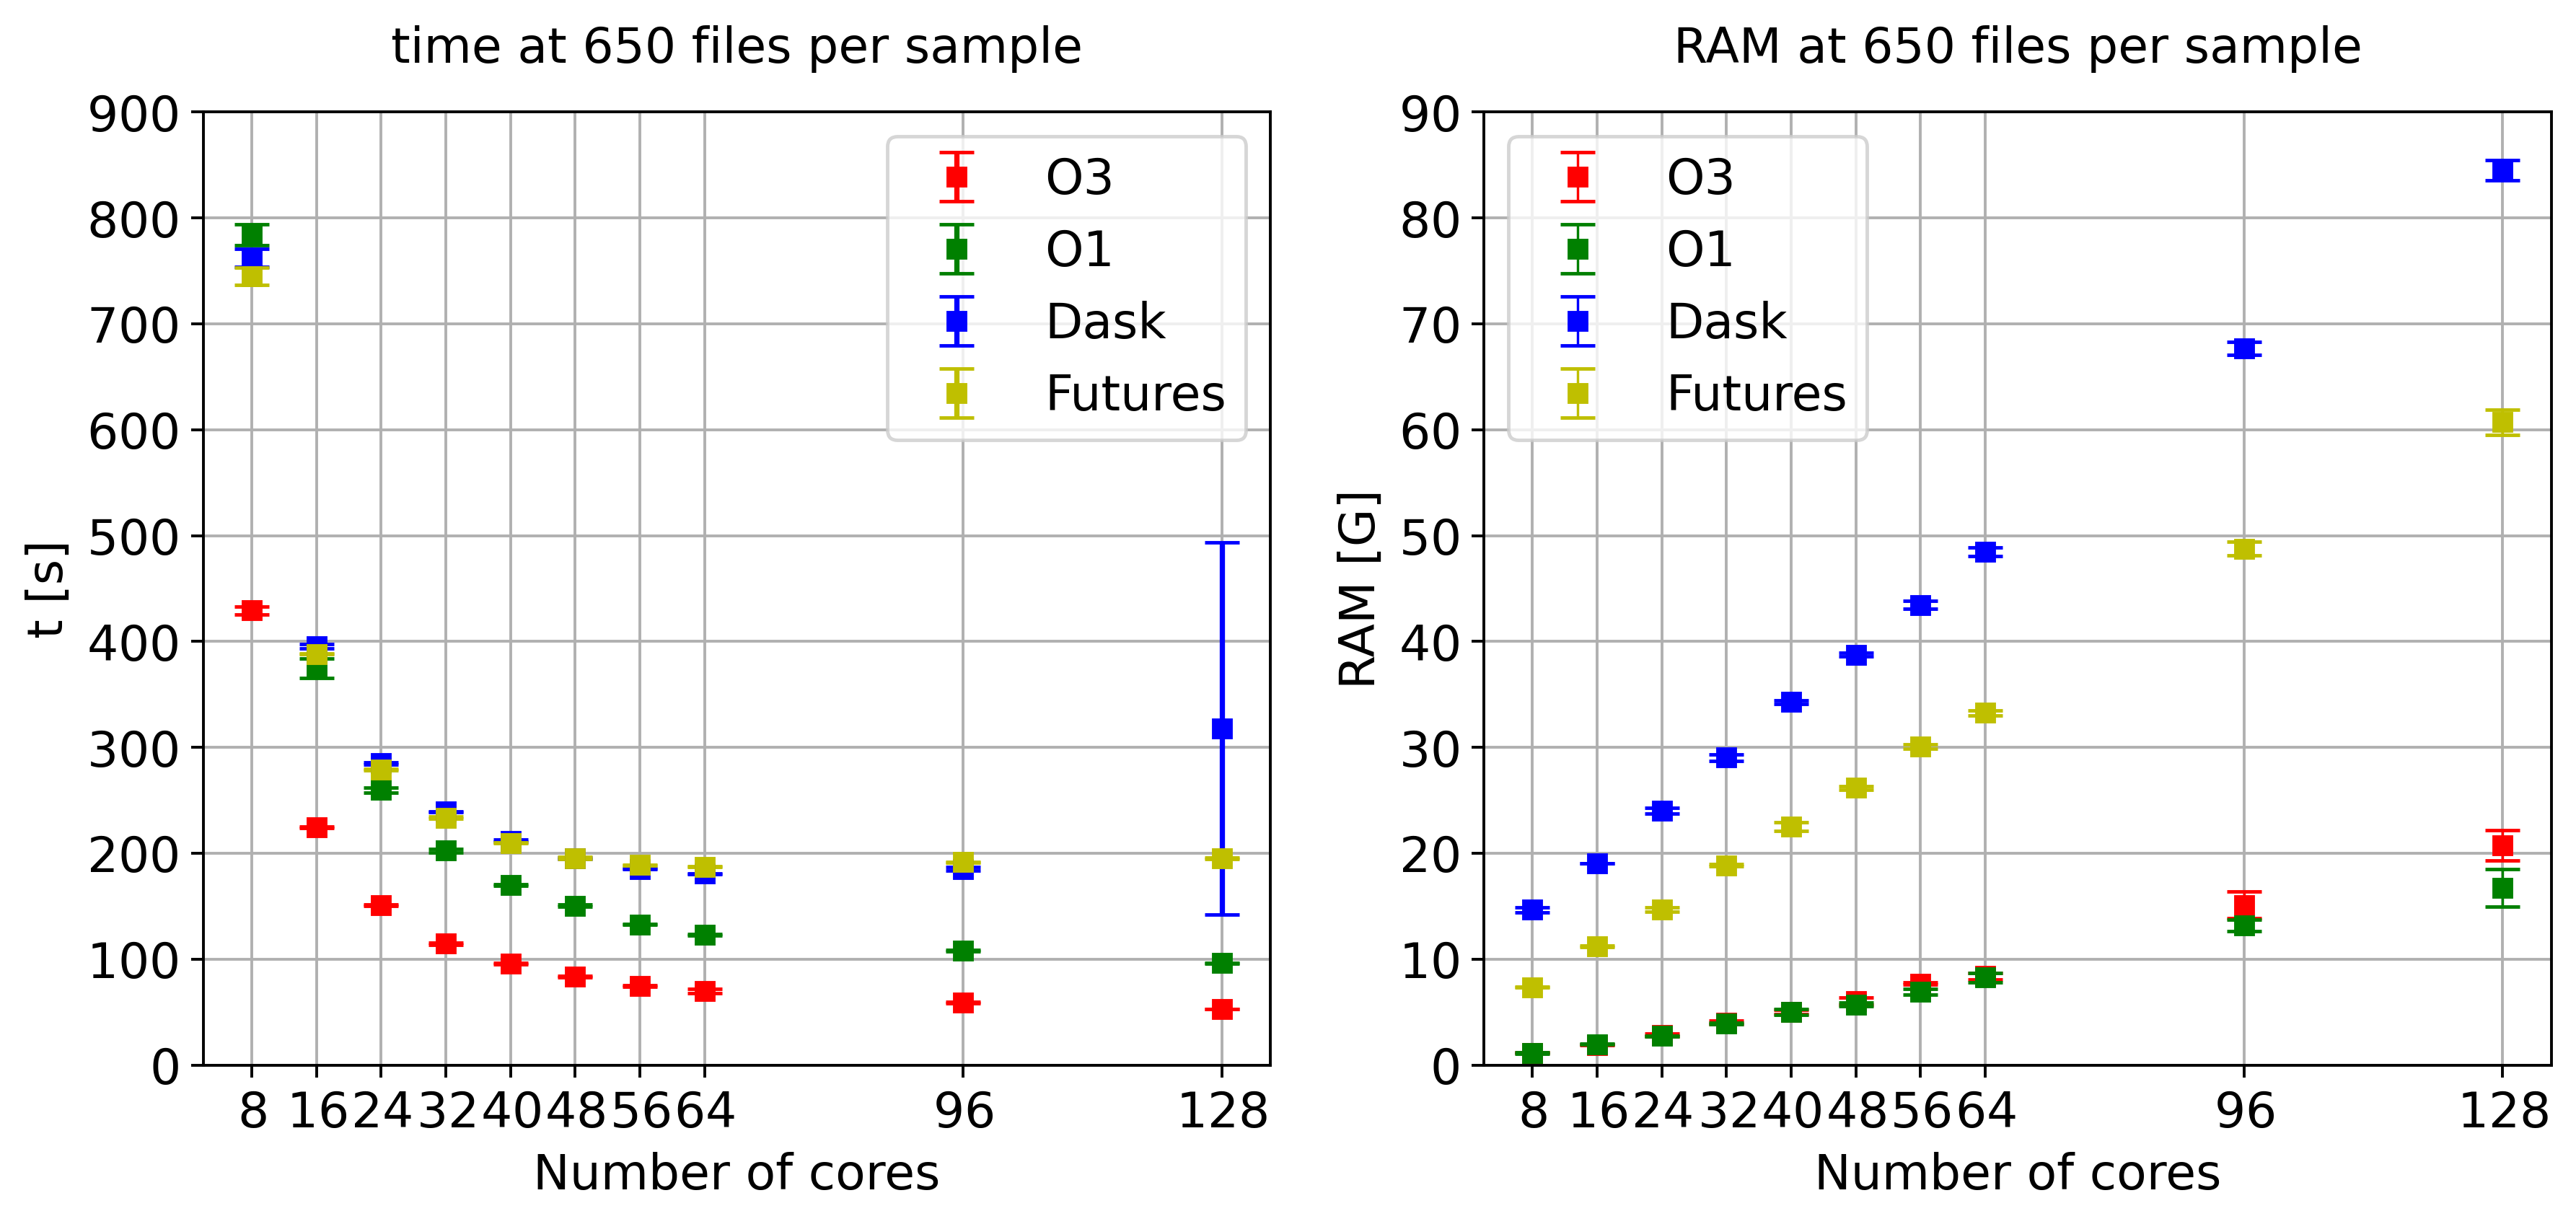

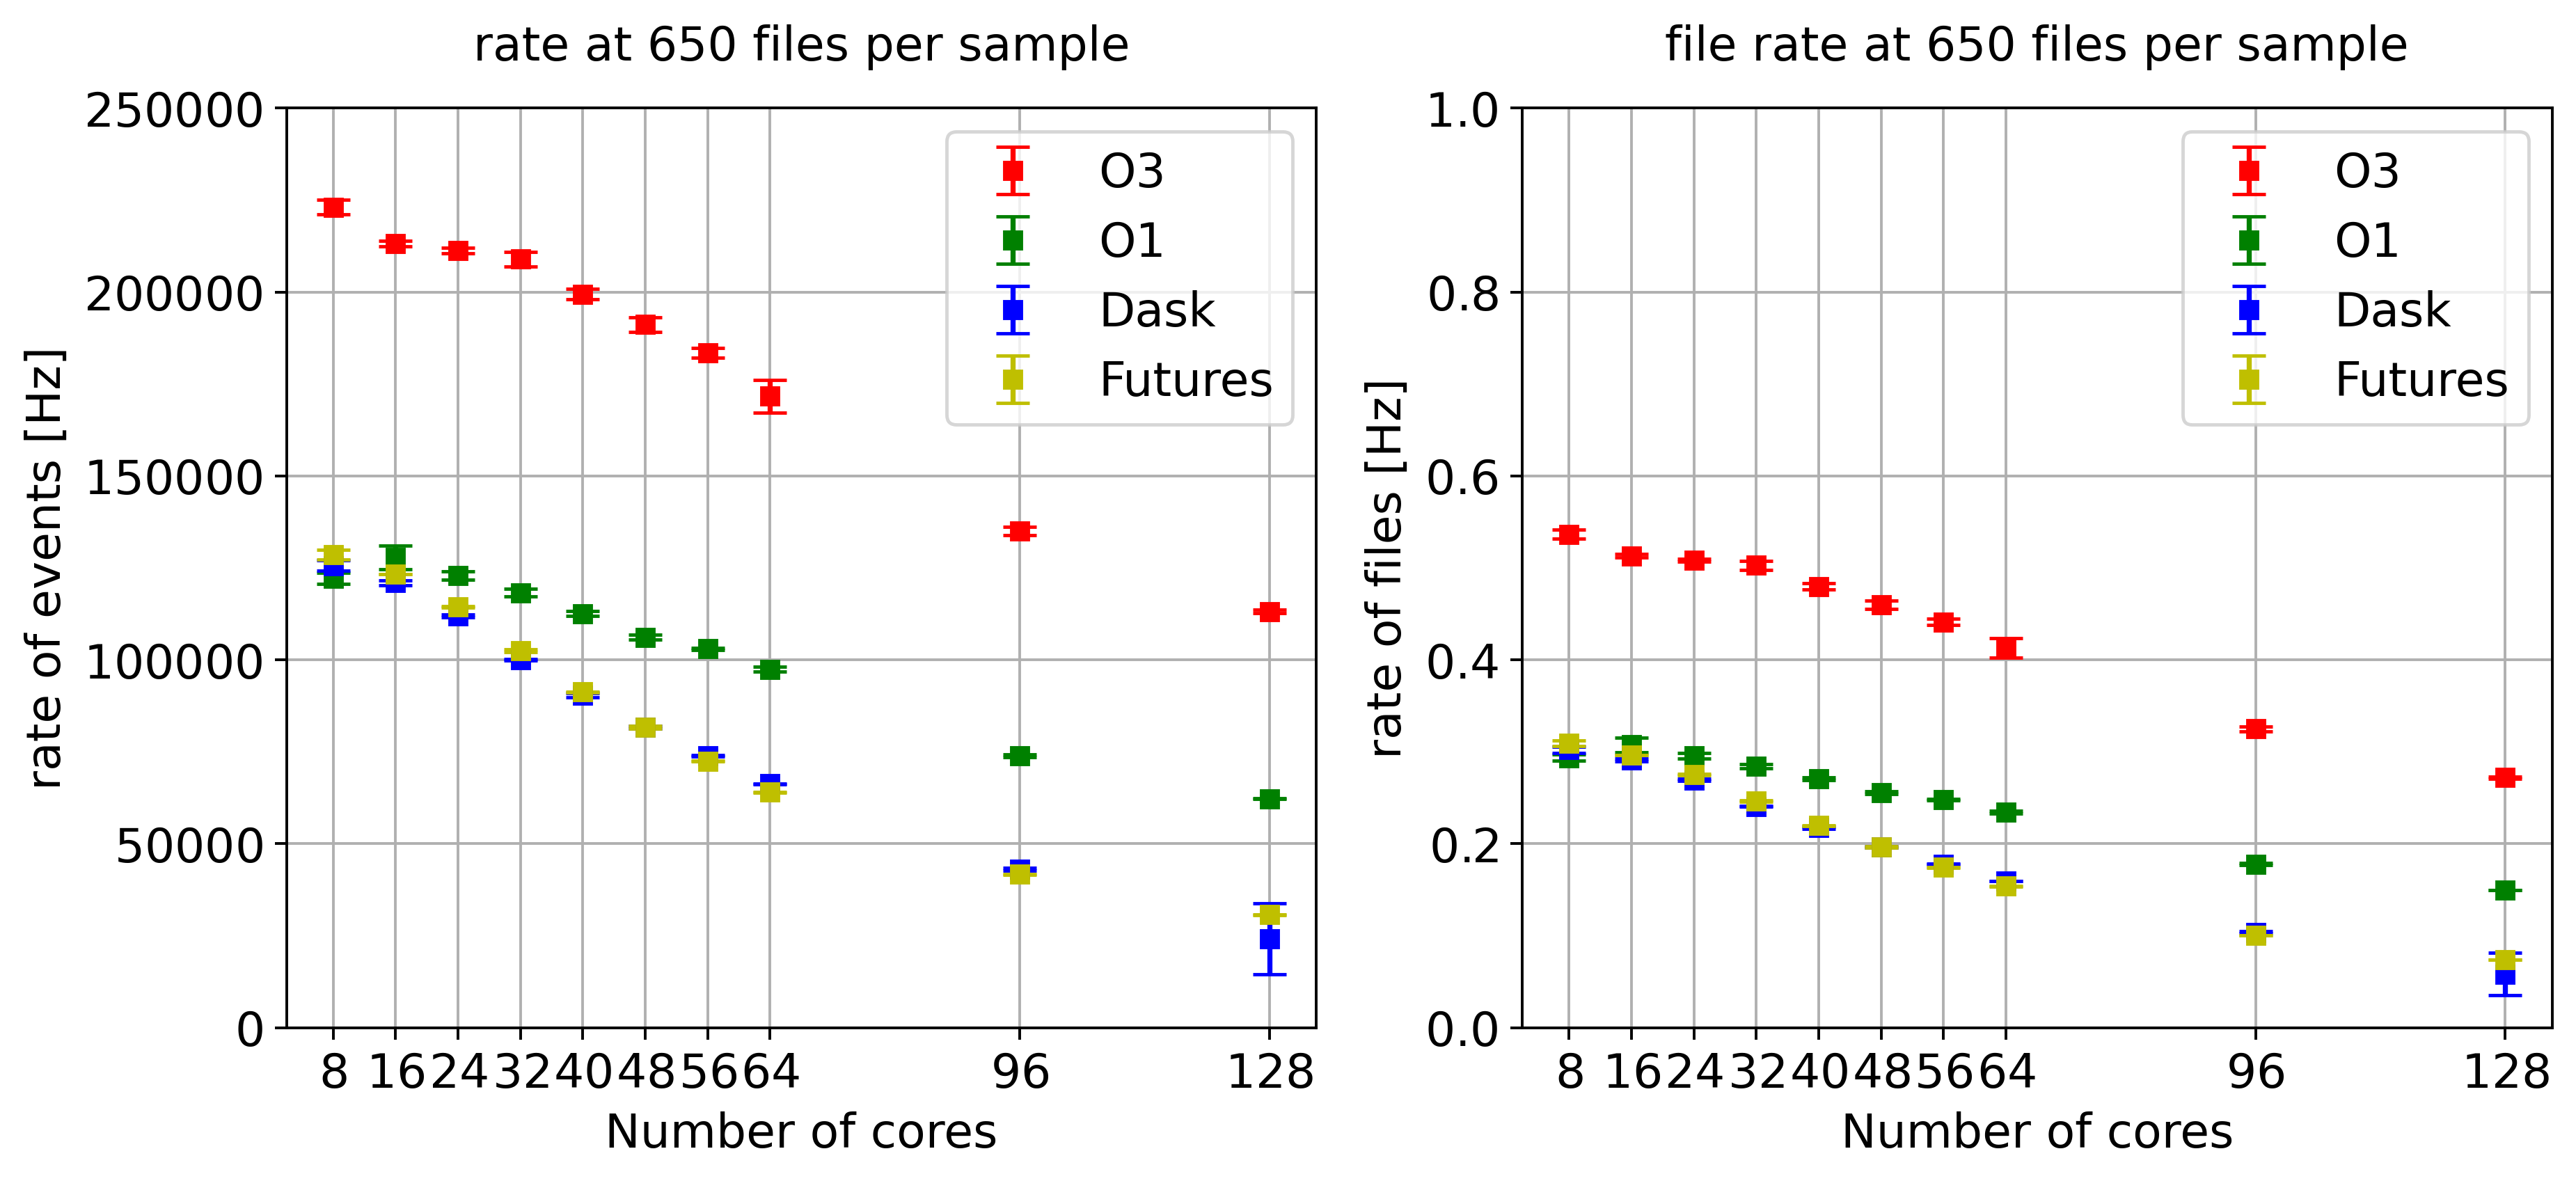

In [5]:
#fs = get_time_vs_ncores(400, ncores_range=range(16,65,16), subdir='old_size/', )
fs1 = get_vs_ncores(650, ncores_range=list(range(8,65,8))+[96,128], labels=['O3', 'O1', 'coffea', 'coffea.FuturesExecutor'])

In [6]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
# plt.rcParams["font.size"] = 12
plt.rcParams["figure.dpi"] = 350
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams["lines.markersize"] = 12
def get_vs_nfiles(ncores=64, nfiles_range=range(50, 650, 50), labels = ['O3', 'coffea'], subdir=''):
#     plt.style.use('_mpl-gallery')
    
    colors = ['r', 'g', 'b', 'y']
    colors = {labels[i]:colors[i] for i in range(len(labels))}
    
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    timeax = ax[0]
    ramax = ax[1]
    timeax.ticklabel_format(axis='x', style='sci')
    
    fig_rate, axs = plt.subplots(1,2, figsize=(12,5)) 
    ax_rate = axs[0]
    ax_file = axs[1]
    
    
    
    n = nfiles_range
    nevts = []
    nfiles_tot = []
    
    for label in labels:
        
        t = []  
        ram = []
        for nfiles in n:
            path = f'benchmarks/{subdir}{nfiles}/{label}/{ncores}/*'
            files = glob.glob(path)
            time = []
            rss = []
   
            for i in range(len(files)):
                
                file = files[i]
                if int(file.split('/')[-1].split('.')[0]) > 3: continue
                
                with open(file, 'r') as f:
                
                    if i == 0 and label=='O3':
                        for l in f.readlines():

                            if 'Total number of events:' in l:
                                val = int(l.split()[-1])
                                nevts.append(val)
                            if 'Total number of files:' in l:
                                val = int(l.split()[-1])    
                                nfiles_tot.append(val)   
                        f.seek(0)    
                    if 'coffea' in label:
                        if 'rss' in file:
                            line = f.readline()
                            val = line.split()[0]
                            rss.append(float(val))
                        elif label == 'coffea':
                            omit_first = False
                            for line in f.readlines():
                                if '100%' in line:
                                    if not omit_first:
                                        omit_first = True
                                        continue
                                    
                                    mins = line.split()[-2].split('min')[0] if 'min' in line else 0
                                    secs = line.split()[-1].split('s')[0] if 's' in file else 0
                                    #print(fil, mins, secs)
                                    time.append(60*float(mins)+float(secs))
                        else:
                            for line in f.readlines():
                                if line.startswith('processing took'):
                                    val = float(line.split()[-2])
                                    time.append(val)                            
                    else:
                        for line in f.readlines():
                            if 'RunGraphs' in line and 'elapsed' in line:
                                val = float(line.split()[-2][0:-1])
                                time.append(val)
                            if 'maxresident' in line:
                                val = int(line.split()[-1].split('maxresident')[0])#/100000
                                rss.append(val)
                        
            t.append(time); ram.append(rss)

        t = np.array(t); ram = np.array(ram)/1e6
        
#         print(t)
#         print(ram)
#         print(np.array(nevts).shape)
#         print(np.array(nfiles_tot).shape)
        
     
        label1 = label.strip('coffea')
        label1 = 'Dask' if len(label1) == 0 else label1
        if label1 == '.FuturesExecutor': label1 = 'Futures'
        timeax.errorbar(n, np.mean(t, axis=1), yerr=np.std(t, axis=1), label = label1, marker='.', linestyle='', color=colors[label], capsize=5)
        ramax.errorbar(n, np.mean(ram, axis=1), yerr=np.std(ram, axis=1), label = label1, marker='.', linestyle='', color=colors[label],linewidth=0.7, capsize=5)
        
        
        rate = np.array(nevts)[:,None]/ncores/t
        ax_rate.errorbar(n, np.mean(rate, axis=1), yerr=np.std(rate, axis=1), label = label1, marker='.', linestyle='', color=colors[label], capsize=5)
        rate = np.array(nfiles_tot)[:,None]/ncores/t
        ax_file.errorbar(n, np.mean(rate, axis=1), yerr=np.std(rate, axis=1), label = label1, marker='.', linestyle='', color=colors[label], capsize=5)
        
    
    timeax.set_xlabel('Number of files per sample')
    timeax.set_ylabel('t [s]')
    timeax.grid()
    timeax.set_xticks(n)
#     ax[0].set_yticks(list(range(0, 1100, 100)))
    #ax[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    timeax.legend()
    timeax.set_title(f'time at {ncores} cores', fontsize=14, x=0.5, y=1.03)
    timeax.set_ylim(0, 200)
 
    ax_rate.set_xlabel('Number of files per sample')
    ax_rate.set_ylabel('rate of event [Hz]')
    ax_rate.grid()
    ax_rate.set_xticks(n)
    ax_rate.legend()
    ax_rate.set_title(f'rate at {ncores} cores', fontsize=14, x=0.5, y=1.03)
    ax_rate.set_ylim(0, 25*1e4)

    
    ramax.set_xlabel('Number of files per sample')
    ramax.set_ylabel('RAM [G]')
    ramax.grid()
    ramax.set_xticks(n)
    ramax.legend()
    ramax.set_title(f'RAM at {ncores} cores', fontsize=14, x=0.5, y=1.03)
    ramax.set_ylim(0, 50)

    ax_file.set_xlabel('Number of files per sample')
    ax_file.set_ylabel('rate of files [Hz]')
    ax_file.grid()
    ax_file.set_xticks(n)
    ax_file.legend()
    ax_file.set_title(f'file rate at {ncores} cores', fontsize=14, x=0.5, y=1.03)
    ax_file.set_ylim(0, 0.6)
    
    
    return (fig, fig_rate)


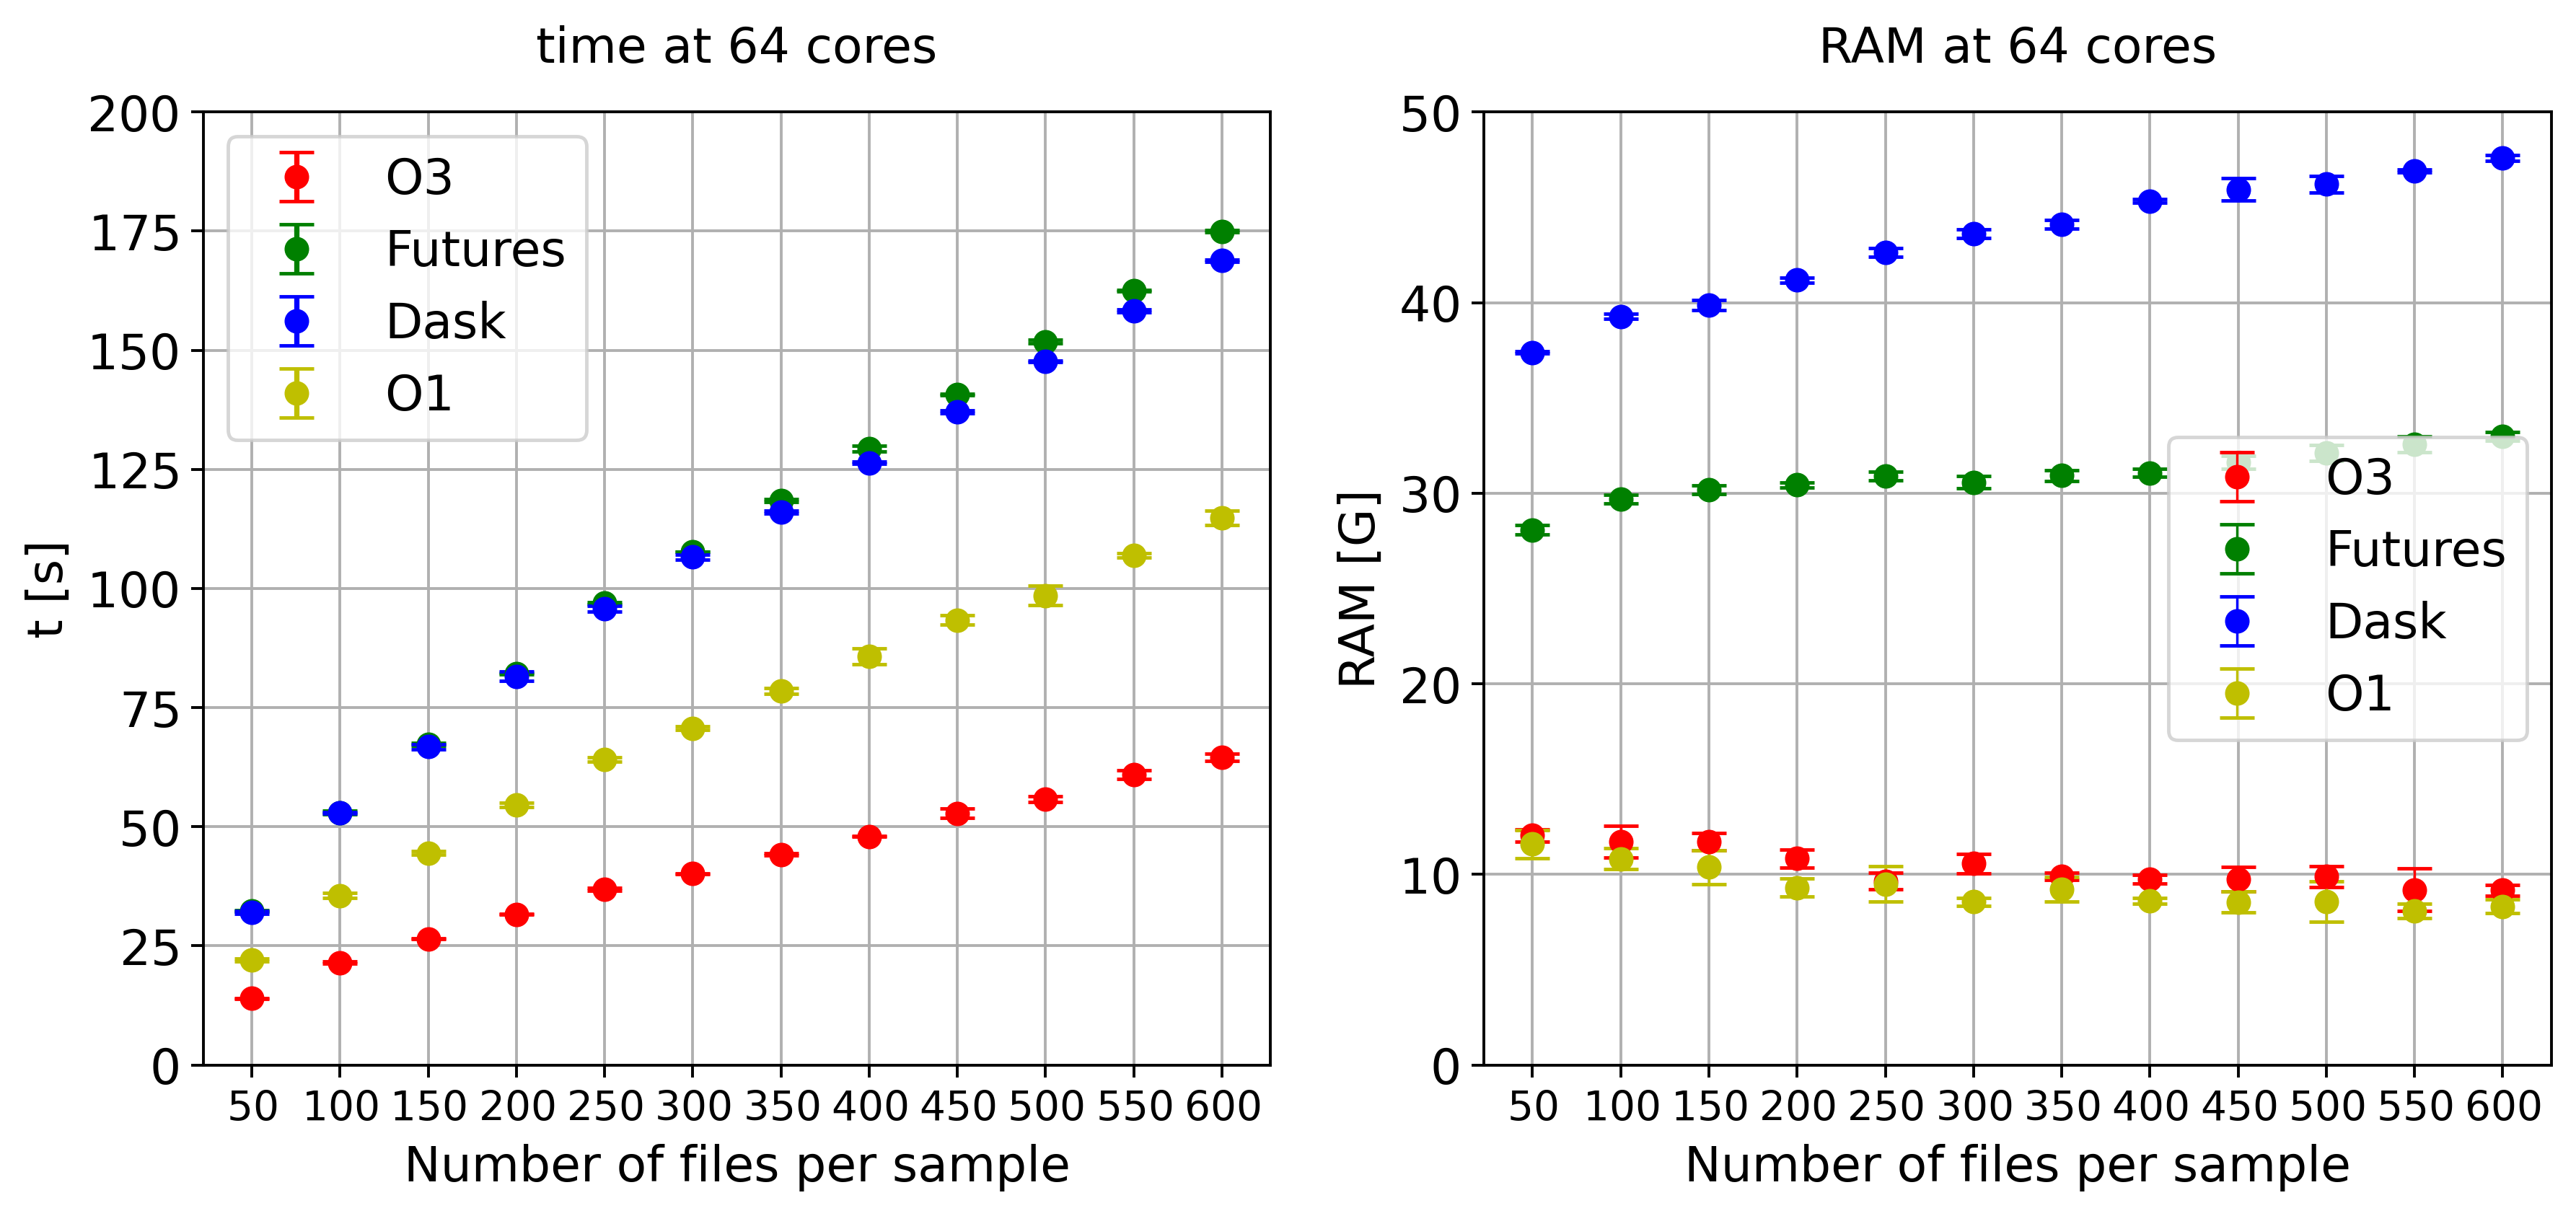

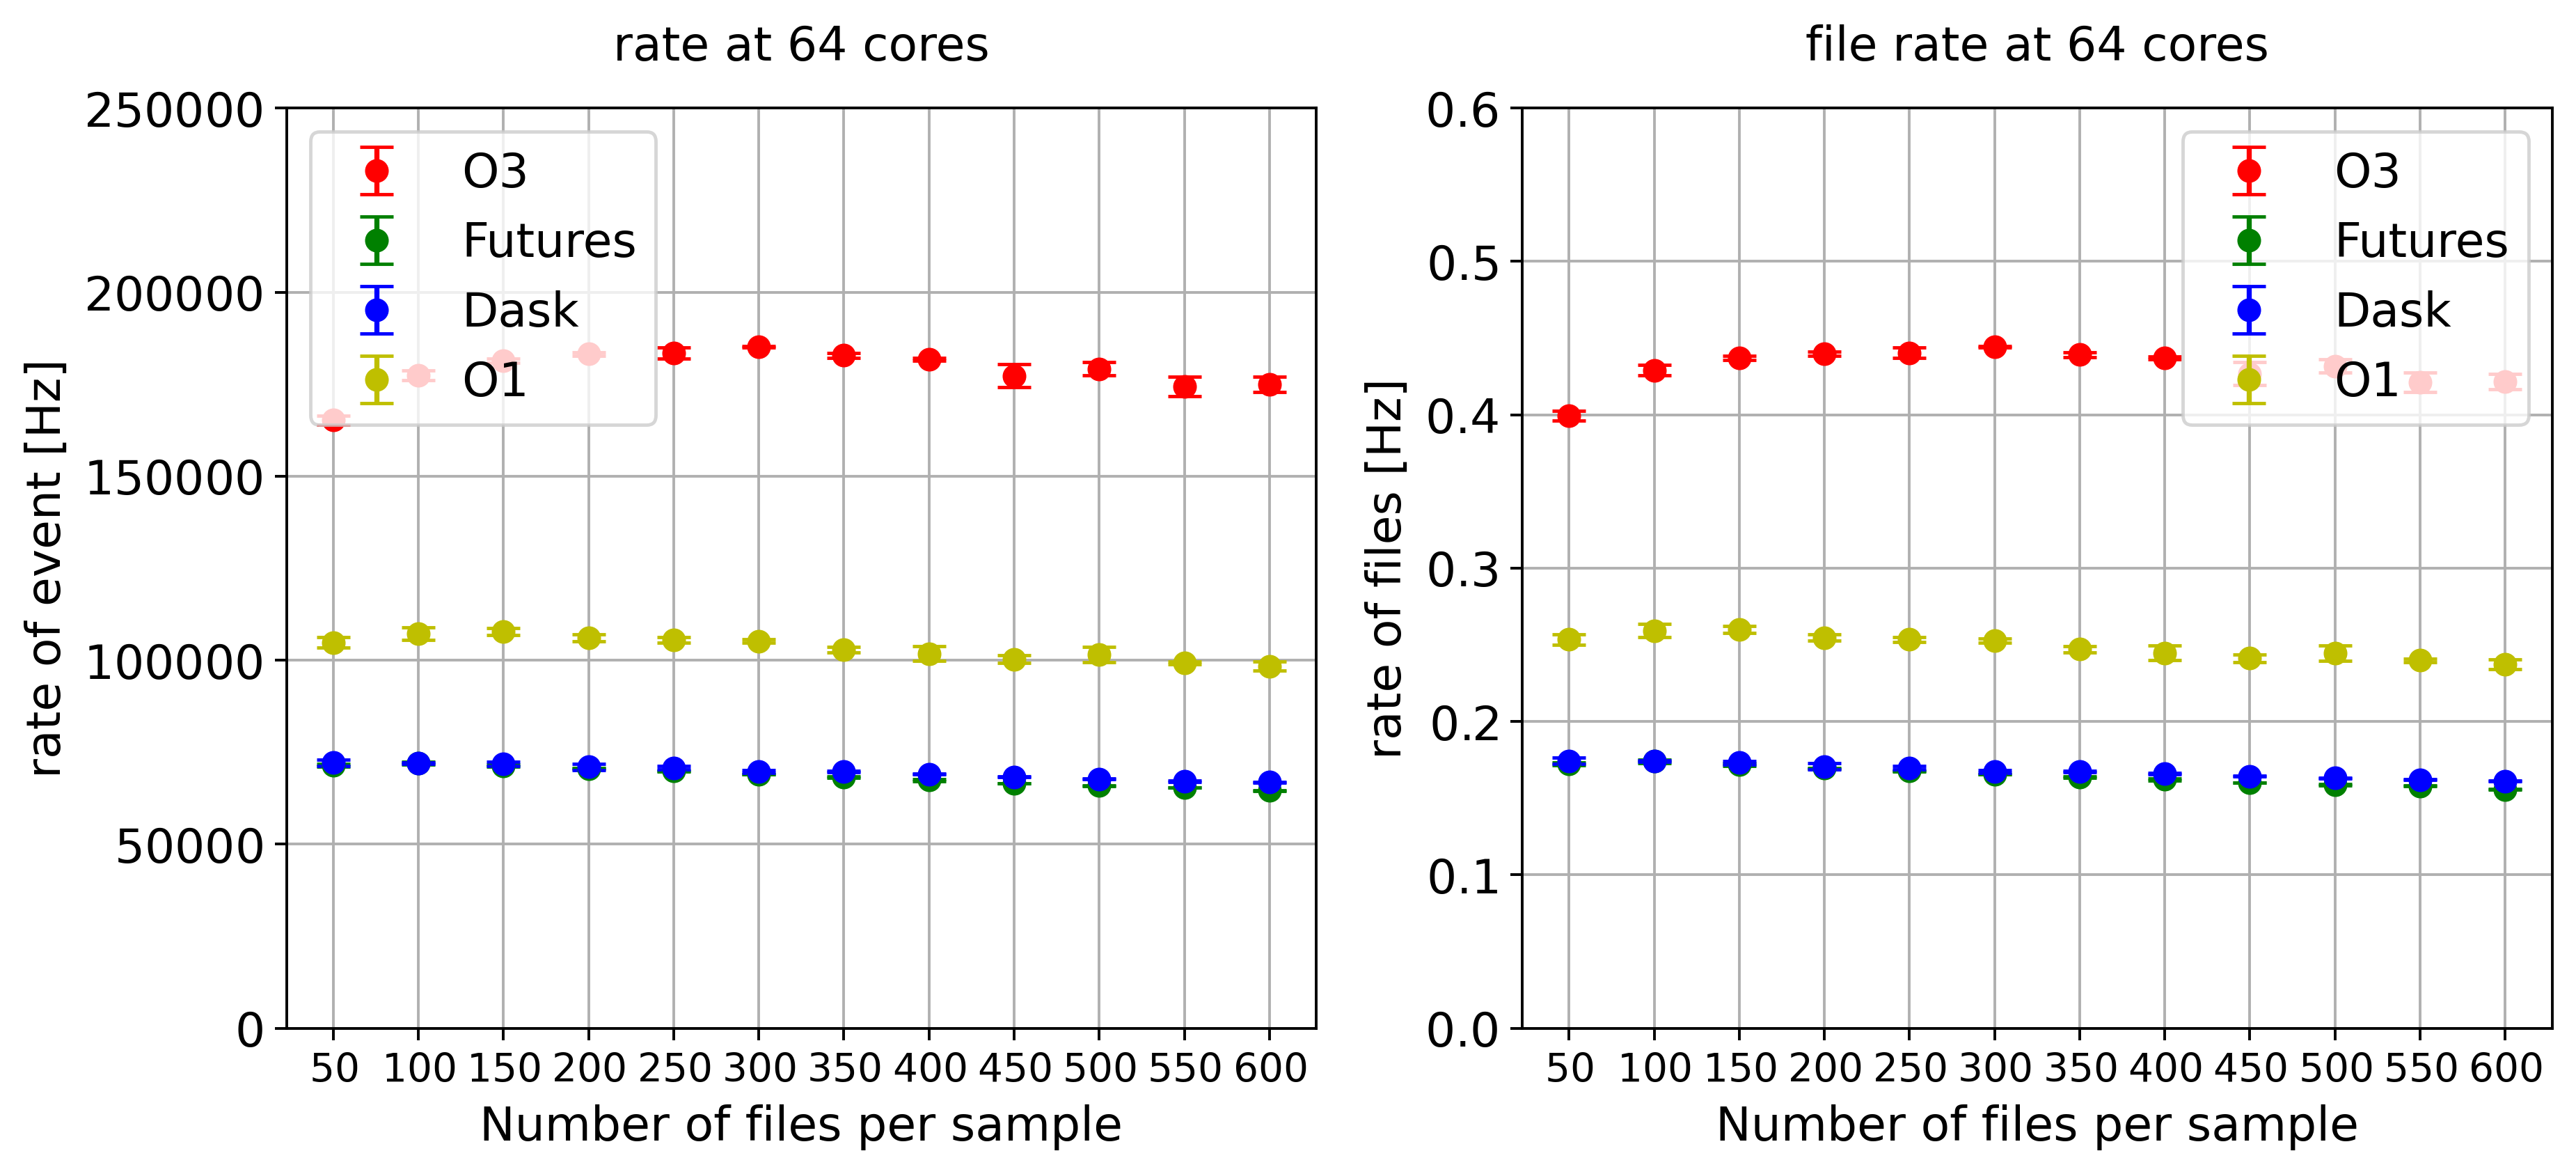

In [7]:
fs2=get_vs_nfiles(labels=['O3','coffea.FuturesExecutor', 'coffea', 'O1'])

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('histograms/plots.pdf')
fs_title = {fs1: 'vs_cores', fs2: 'vs_times'}
for fs in [fs1, fs2]:
    subtitle = ['time', 'rate']
    for i in range (2):
        fs[i].savefig(f'histograms/{fs_title[fs]}_{subtitle[i]}.png')
        pp.savefig(fs[i])
pp.close()